In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import glob
import cv2
import os
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
from imutils import contours
import imutils
import scipy.misc as sm
import time
from numba import *
import numpy as np
import cv2
from timeit import default_timer as timer

%matplotlib inline

Using TensorFlow backend.


In [2]:
odmodel = load_model('aug_inverter_on_all_imagesx5.h5')

In [23]:

#@guvectorize(['np.array(..., dtype=np.float64),float32[:,:](float64[:,:,:],uint8[:,:,:])'],"(m,n),(n,p)->(m,p)",target='cuda')
def predictor(full_image_pred,full_image):
    phaltu_time = timer()
    image = full_image_pred
    image[image<190] = 0
    
    cx_cord = []

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred,190, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue


        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255

        numPixels = cv2.countNonZero(labelMask)

        if numPixels > 150:
            mask = cv2.add(mask, labelMask)


    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    image = full_image
    
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        
        cx_cord.append(cX)

        rect = cv2.fitEllipse(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        #cv2.drawContours(image,[box],0,(255,255,0),2)
        cv2.drawContours(image,[box],0,(255/255,255/255,0),2)

    #plt.imshow(image,vmin = 0, vmax = 255)
    print("Total cars predicted = ", len(cx_cord))
    print(timer() - phaltu_time)
    return image

In [7]:
def predictor1(full_image_pred,full_image):
    phaltu_time = timer()
    image = full_image_pred
    image[image<190] = 0

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred,190, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = np.asarray(thresh, dtype = 'uint8')

    thresh[thresh>190] = 255

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    image = full_image
    cars = 0
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        
        
        if w*h < 160:
            continue
        cars = cars + 1    
        rect = cv2.fitEllipse(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(image,[box],0,(255/255,255/255,0),2)

    plt.imshow(image,vmin = 0, vmax = 255)
    print("Total cars predicted = ", cars)
    print(timer() - phaltu_time)
    return image

In [8]:
def cropper(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    
    return cropped_img

In [9]:
@jit(["void(float32,float32,int64,int64)"])
def place(prediction,full_image_p,y,x):
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])


100
200
Total cars predicted =  93
0.03435618500009241
2.930643195911183
200
Total cars predicted =  82
0.009777848999988237
7.544973398389455
200
Total cars predicted =  83
0.011653437999939342
7.603773332972209
200
Total cars predicted =  81
0.012384955000015907
7.750666875127304
200
Total cars predicted =  82
0.013497806000032142
7.466519733526371
200
Total cars predicted =  84
0.011962904000029084
7.7815598493130835
200
Total cars predicted =  84
0.01377668200007065
7.694611340561834
200
Total cars predicted =  84
0.012619271999938064
8.055039504976445
200
Total cars predicted =  89
0.013847081999983857
7.938719373900829
200
Total cars predicted =  94
0.012649303999978656
7.613679467444935
200
Total cars predicted =  93
0.013852599999950144
7.364814502967648
200
Total cars predicted =  93
0.018412955999906444
7.45904760955695
200
Total cars predicted =  96
0.013592649999964124
7.619189495608793
200
Total cars predicted =  91
0.01284911999994165
7.793342928031096
200
Total cars pred

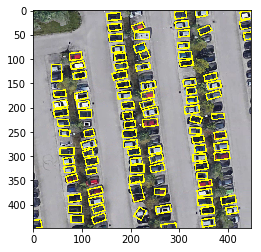

In [10]:
cap = cv2.VideoCapture('videos/test1.mp4')
i = 1
while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    if i%100==0:
        print(i)
    
    if i <200:
        i = i + 1
        continue
       
    dur = 0
    
    start = timer()
    full_image = frame[0:448,0:448]
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    full_image = np.asarray(full_image,dtype = np.float32)
    full_image_p = np.zeros((448,448),dtype = np.float32)
    for x in range(2):
        for y in range(2):
            img_part = cropper(full_image,y*224,x*224) # overlap = 16 therefore (224 - 16 = 208)
            img_part = np.asarray(img_part)
            img_part = img_part.reshape((1,224,224,3))
            img_part = 255 - img_part
            start1 = timer()
            prediction = odmodel.predict(img_part)
            dur = dur + timer() - start1
            prediction = np.asarray(prediction,dtype = np.float32)
            #prediction = np.asarray(prediction)
            prediction = prediction.reshape((1,224,224))
            #print(x," ",y)
            place(prediction,full_image_p,y*224,x*224)
            #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
    bounded_image = predictor1(full_image_p,full_image/255)   
    bounded_image = cv2.cvtColor(bounded_image, cv2.COLOR_BGR2RGB)
    cv2.imshow('frame',bounded_image)
    #print(cap.get(5))
    end = timer() - start
    print(1/(end))
    #print(end)
    #print(dur)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
